In [1]:
import anndata as ad
import crested

adata = ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral_dars.h5ad")

2025-08-05 10:22:56.099718: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 10:22:56.745448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754414576.977446   13626 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754414577.050673   13626 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-05 10:22:57.650142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import os
os.environ["PATH"] = "/home/niklas.kempynck/meme/bin:" + os.environ["PATH"]
meme_db, motif_to_tf_file = crested.get_motif_db()

In [3]:
CONTRIB_DIR = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/"

In [ ]:
%matplotlib inline
top_k = 500
crested.pl.patterns.modisco_results(
    classes=["Human-14", "Human-31", "Human-7"],
    contribution="positive",
    contribution_dir=CONTRIB_DIR,
    num_seq=top_k,
    y_max=0.15,
    viz="pwm",
)  # You can also visualize in 'pwm' format

2025-08-05T10:23:21.534760-0700 INFO Starting genomic contributions plot for classes: ['Human-14', 'Human-31', 'Human-7']


In [42]:
# First we obtain the resulting modisco files per class
matched_files = crested.tl.modisco.match_h5_files_to_classes(
    contribution_dir=CONTRIB_DIR, classes=list(adata.obs_names)
)

In [43]:
sim_matrix, pattern_ids, pattern_dict = crested.tl.modisco.calculate_tomtom_similarity_per_pattern(
    matched_files = matched_files,
    trim_ic_threshold=0.025,
    verbose=True
)

Reading file /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-14_modisco_results.h5
Reading file /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-31_modisco_results.h5
Reading file /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-7_modisco_results.h5
Total patterns: 58


In [44]:
import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex

groups = []
for id in pattern_ids:
    ct = '_'.join(id.split('_')[:-3])
    groups.append(ct)

unique_cats = pd.unique(groups)
group_colors = {"Human-14": 'lightgreen', "Human-31": 'orange', "Human-7": 'darkblue'}

/home/niklas.kempynck/wandb_tmp/ipykernel_1992437/1619164829.py:10: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_cats = pd.unique(groups)


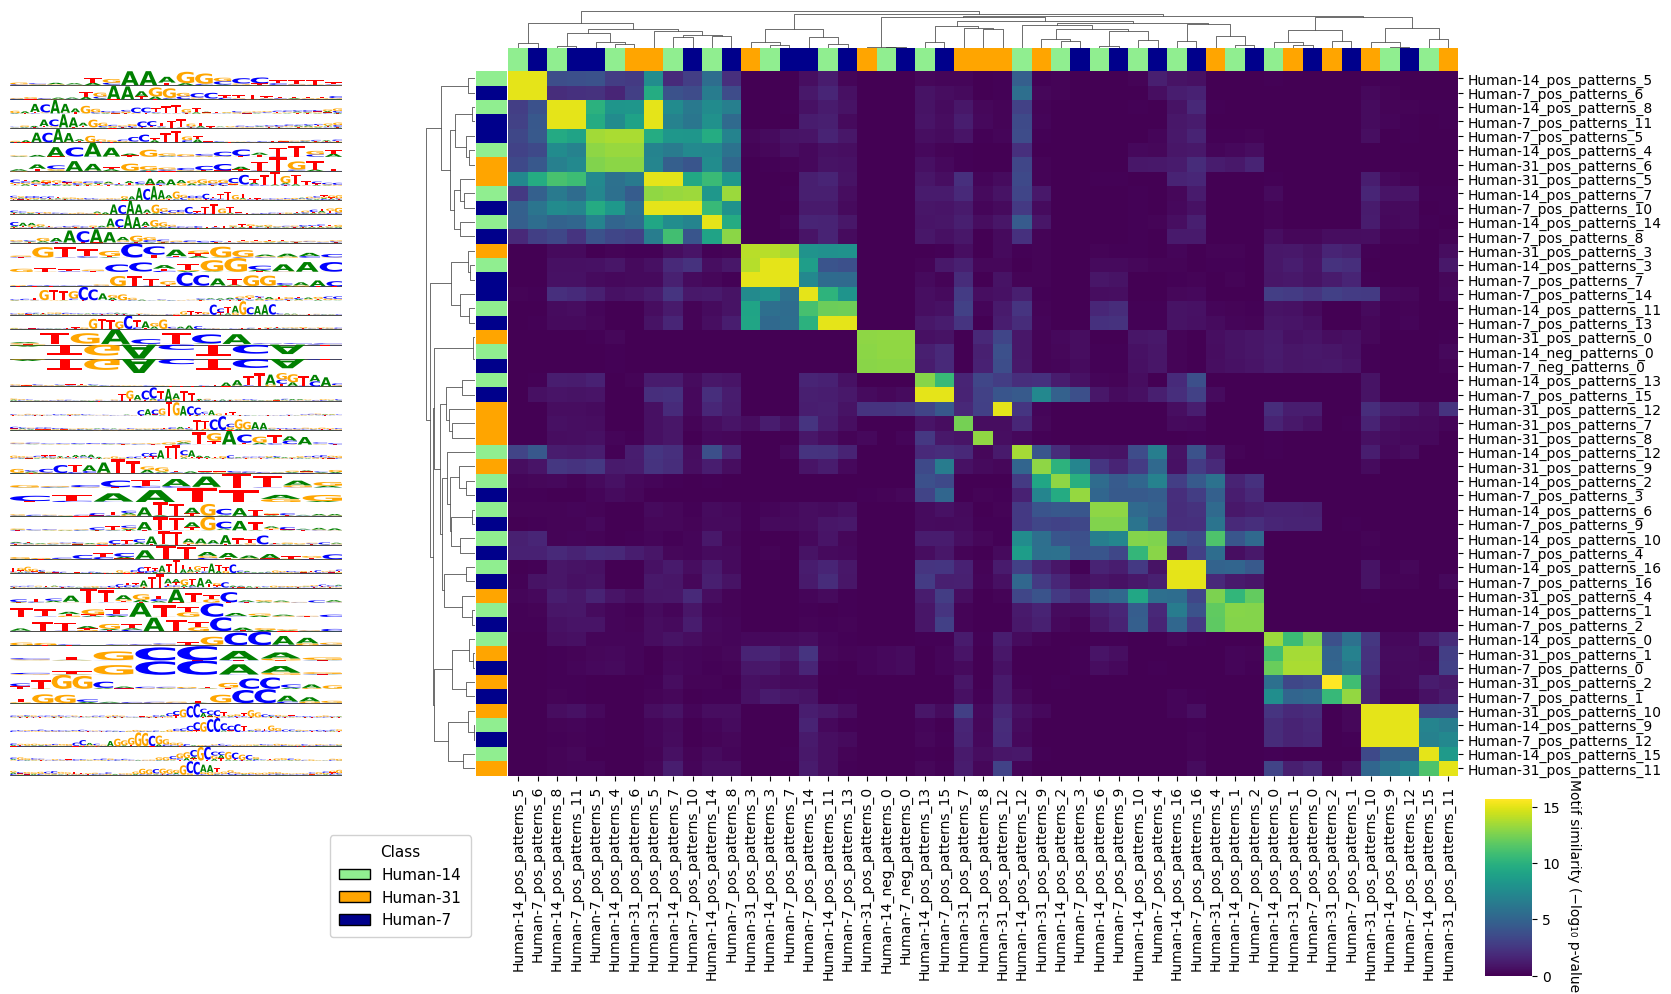

In [45]:
%matplotlib inline
crested.pl.patterns.clustermap_tomtom_similarities(
    sim_matrix=sim_matrix,
    ids=pattern_ids,
    pattern_dict=pattern_dict,
    group_info = [(groups, group_colors)], # Grouping labels
    min_seqlets=30, # Add a minimum amount of seqlets to take the most relevant patterns
)

In [46]:
# Then we cluster matching patterns, and define a pattern matrix [#classes, #patterns] describing their importance
all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=8,  # The similarity threshold used for matching patterns. We take the -log10(pval), pval obtained through TOMTOM matching from memesuite-lite
    trim_ic_threshold=0.025,  # Information content (IC) threshold on which to trim patterns
    discard_ic_threshold=0.2,  # IC threshold used for discarding single instance patterns
    verbose=True,  # Useful for doing sanity checks on matching patterns
)

Reading file /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-14_modisco_results.h5
Match between Human-14_pos_patterns_8 and Human-14_pos_patterns_7 with similarity score 8.38
Reading file /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-31_modisco_results.h5
Match between Human-31_pos_patterns_0 and Human-14_neg_patterns_0 with similarity score 15.00
Match between Human-31_pos_patterns_1 and Human-14_pos_patterns_0 with similarity score 11.02
Match between Human-31_pos_patterns_3 and Human-14_pos_patterns_3 with similarity score 15.00
Match between Human-31_pos_patterns_4 and Human-14_pos_patterns_1 with similarity score 11.88
Match between Human-31_pos_patterns_5 and Human-14_pos_patterns_8

In [47]:
pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(adata.obs_names),
    all_patterns=all_patterns,
    normalize=False,
    pattern_parameter="seqlet_count_log",
)
pattern_matrix.shape

(3, 26)

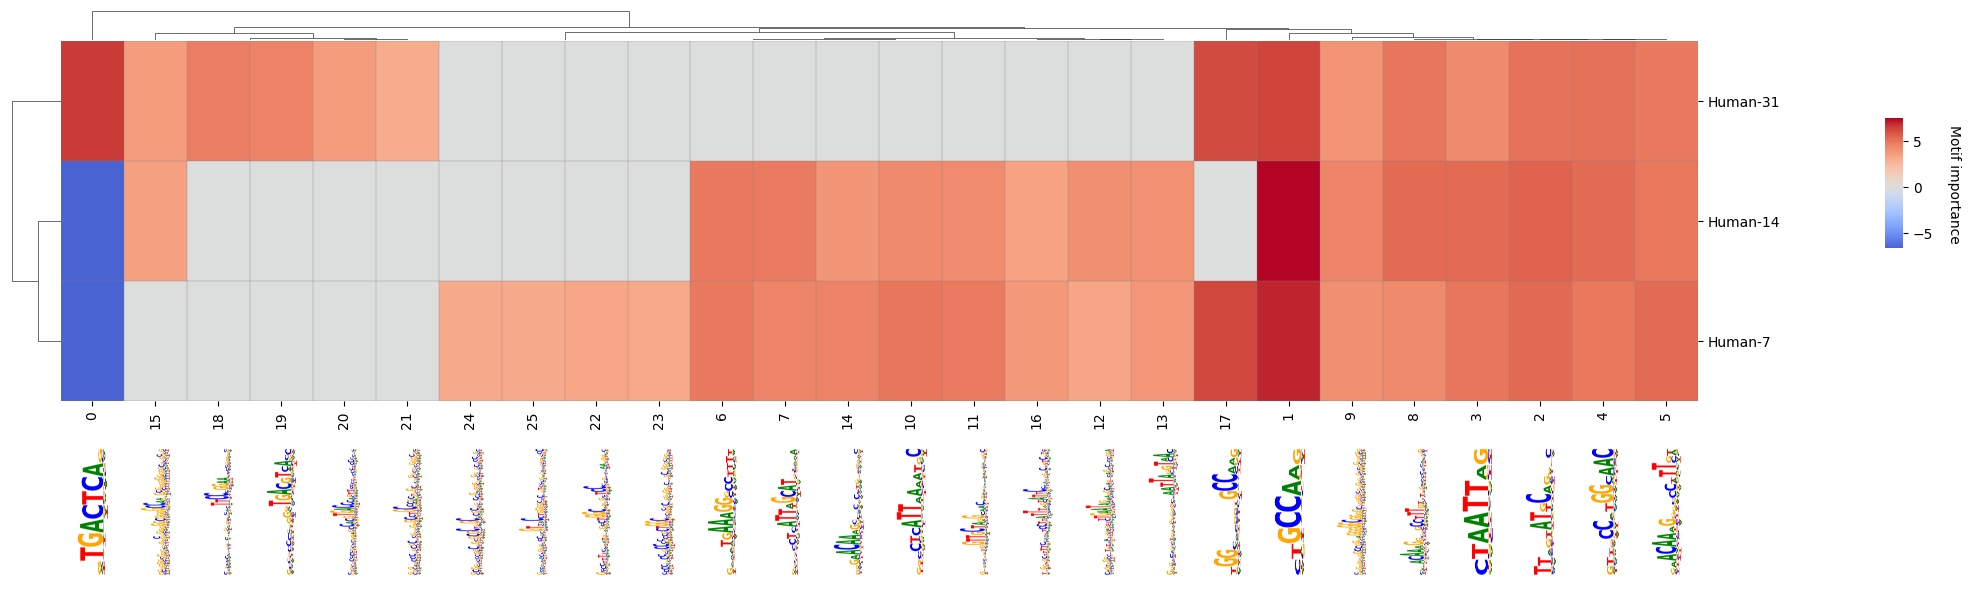

In [48]:
%matplotlib inline
crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix,
    list(adata.obs_names),
    pattern_dict=all_patterns,
    figsize=(18, 3),
    grid=True,
    dendrogram_ratio=(0.03, 0.08),
    importance_threshold=3,  # 3.5,
    logo_height_fraction=0.45,
    logo_y_padding=0.2,
)

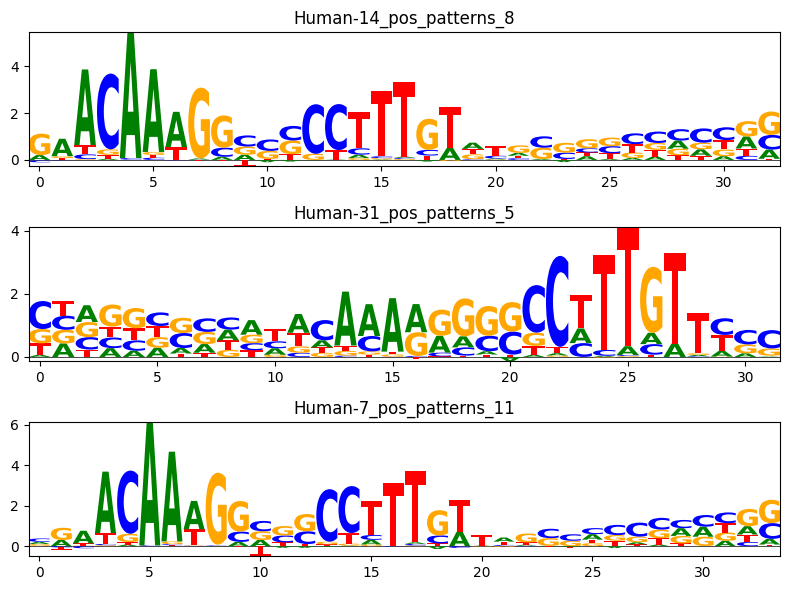

In [49]:
crested.pl.patterns.class_instances(all_patterns, 8,class_representative=True)

# Matching to snRNA

In [50]:
import crested
import anndata

file_path = (
    "/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/Astro/HMBA_human_Astro_3subGroups.h5ad"  # Locate h5 file containing scRNAseq data
)

adata_ = anndata.read_h5ad(file_path)

In [51]:
cell_type_column = "Cluster"
mean_expression_df = crested.tl.modisco.calculate_mean_expression_per_cell_type(
    file_path, cell_type_column, cpm_normalize=False
)

/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/crested/tl/modisco/_tfmodisco.py:1625: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expression_per_cell_type: pd.DataFrame = gene_expression_df.groupby(


In [52]:
mean_expression_df

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
Cluster,,,,,,,,,,,,,,,,,,,,,
Human-7,0.000000,0.0,0.000000,0.040132,0.002331,0.000000,0.136268,0.000000,0.002666,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.068659,0.518110
Human-14,0.000666,0.0,0.000000,0.058847,0.000992,0.000299,0.138399,0.000848,0.000948,0.000072,...,0.0,0.0,0.000082,0.000149,0.000000,0.0,0.000558,0.002763,0.075388,0.577435
Human-28,0.000000,0.0,0.000000,0.078923,0.003207,0.000000,0.125686,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.003491,0.113114,0.257314
Human-31,0.000000,0.0,0.001169,0.023691,0.001108,0.000000,0.078735,0.001368,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.002592,0.051124,0.257716
Human-145,0.000000,0.0,0.000000,0.055353,0.003189,0.000000,0.110302,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.002428,0.053442,0.570764
Human-146,0.000000,0.0,0.000000,0.024038,0.000000,0.000000,0.280681,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.180483
Human-149,0.000000,0.0,0.000000,0.036013,0.000000,0.000000,0.089128,0.001793,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.006018,0.075282,0.296424
Human-150,0.000000,0.0,0.000000,0.025557,0.000000,0.000000,0.113296,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.002856,0.069241,0.146151
Human-152,0.000000,0.0,0.000000,0.021589,0.000000,0.000000,0.097775,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.009766,0.093462,0.281216


In [53]:
mean_expression_df = mean_expression_df.loc[['Human-14', 'Human-31', 'Human-7']]


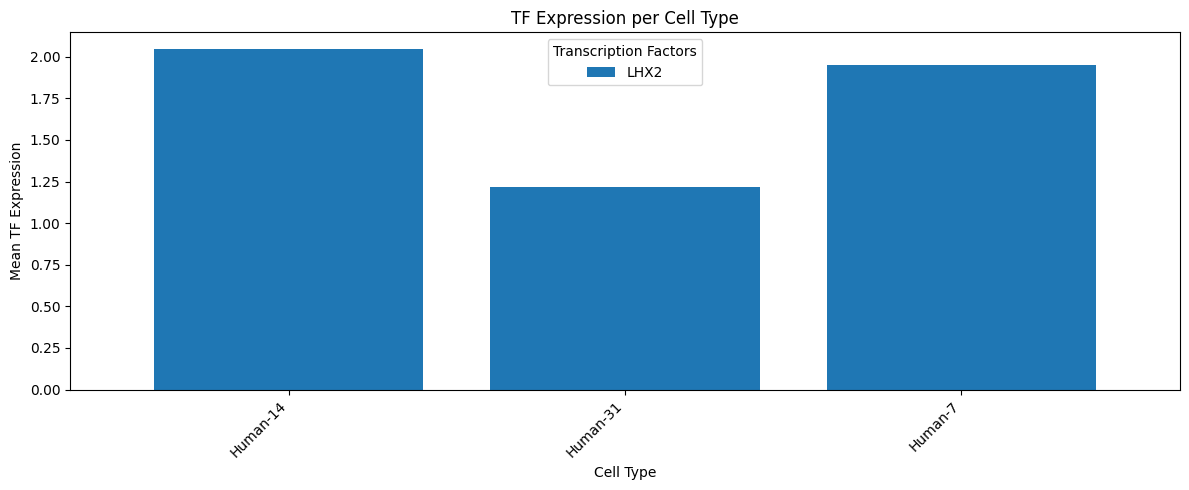

In [54]:
crested.pl.patterns.tf_expression_per_cell_type(
    mean_expression_df, ["LHX2"]
)

In [55]:
adata = ad.read_h5ad("/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral_dars.h5ad")
classes = list(adata.obs_names)

contribution_dir = CONTRIB_DIR
html_paths = crested.tl.modisco.generate_html_paths(
    all_patterns, classes, contribution_dir
)

pattern_match_dict = crested.tl.modisco.find_pattern_matches(
    all_patterns, html_paths, q_val_thr=0.05
)  # q_val threshold to only select significant matches

/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/crested/tl/modisco/_modisco_utils.py:504: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dfs = pd.read_html(source)


2025-08-03T22:00:02.323649-0700 WARNING Skipping pattern match: expected DataFrame but got str.
Problematic HTML path: /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-7_report/motifs.html
2025-08-03T22:00:02.334223-0700 WARNING Skipping pattern match: expected DataFrame but got str.
Problematic HTML path: /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-7_report/motifs.html
2025-08-03T22:00:02.344263-0700 WARNING Skipping pattern match: expected DataFrame but got str.
Problematic HTML path: /allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-7_repor

/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/pandas/io/html.py:661: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a filename than HTML or XML.

If you meant to use Beautiful Soup to parse the contents of a file on disk, then something has gone wrong. You should open the file first, using code like this:

    filehandle = open(your filename)

You can then feed the open filehandle into Beautiful Soup instead of using the filename.

However, if you want to parse some data that happens to look like a filename, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  soup = BeautifulSoup(udoc, features="html5lib", fr

In [56]:
html_paths

[['/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-14_report/motifs.html',
  '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-31_report/motifs.html',
  '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-7_report/motifs.html'],
 ['/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/Human-14_report/motifs.html',
  '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-g

In [57]:
meme_db, motif_to_tf_file = crested.get_motif_db()
motif_to_tf_df = crested.tl.modisco.read_motif_to_tf_file(
   motif_to_tf_file
)

In [58]:
cols = [
    "Mouse_Direct_annot",
    "Mouse_Orthology_annot",
    "Cluster_Mouse_Direct_annot",
    "Cluster_Mouse_Orthology_annot",
]
cols = [
    "Human_Direct_annot",
    "Human_Orthology_annot",
    "Cluster_Human_Direct_annot",
    "Cluster_Human_Orthology_annot",
]
pattern_tf_dict, all_tfs = crested.tl.modisco.create_pattern_tf_dict(
    pattern_match_dict, motif_to_tf_df, all_patterns, cols
)
tf_ct_matrix, tf_pattern_annots = crested.tl.modisco.create_tf_ct_matrix(
    pattern_tf_dict,
    all_patterns,
    mean_expression_df,
    classes,
    log_transform=False,
    normalize_pattern_importances=False,
    normalize_gex=True,
    min_tf_gex=0.95,
    importance_threshold=4,
    pattern_parameter="seqlet_count_log",
    filter_correlation=True,
    verbose=True,
    zscore_threshold=1.1,
    correlation_threshold=0.9,
)

Total columns before threshold filtering: 280
Total columns after threshold filtering: 184
Total columns removed: 96
Total columns before correlation filtering: 184
Total columns after correlation filtering: 28
Total columns removed: 156


/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/crested/pl/patterns/_modisco_results.py:1108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


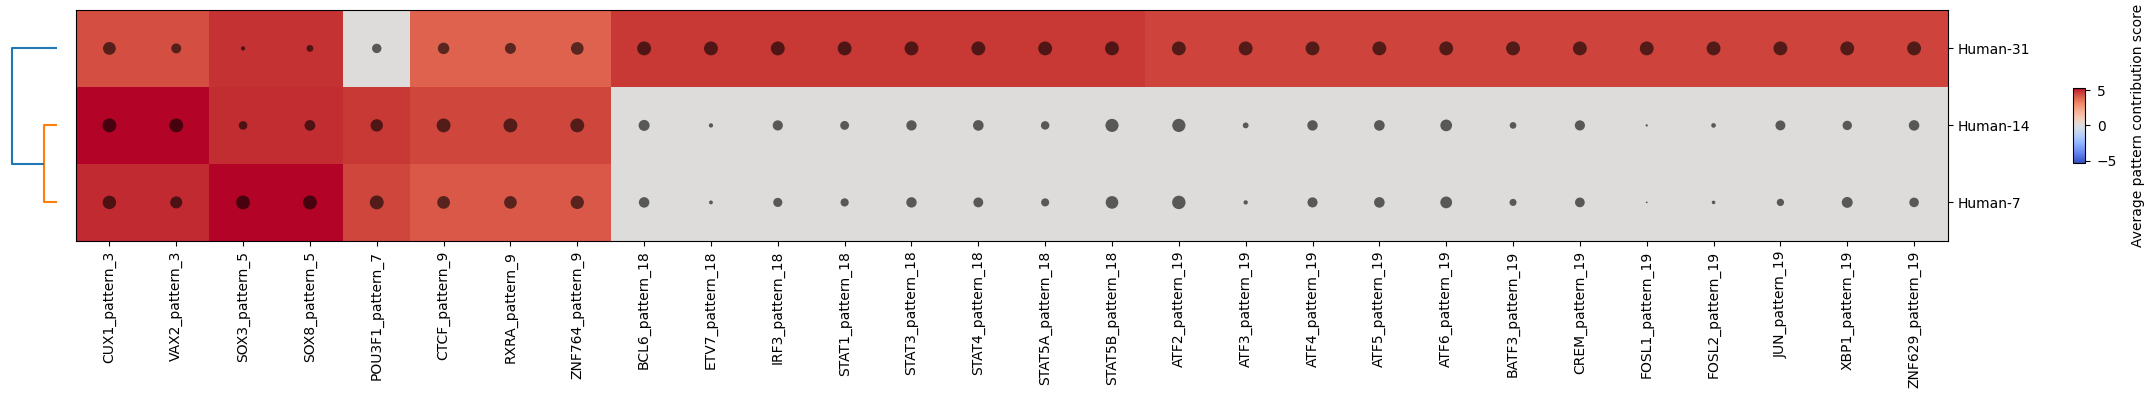

In [59]:
crested.pl.patterns.clustermap_tf_motif(
    tf_ct_matrix,
    heatmap_dim="contrib",
    dot_dim="gex",
    class_labels=classes,
    pattern_labels=tf_pattern_annots,
    fig_size=(25, 3),
    cluster_rows=True,
    cluster_columns=False,
)

# Combined modisco run

In [5]:
import h5py
from collections import defaultdict

def load_hdf5_group(group):
    """Recursively load an h5py group into a nested dictionary."""
    result = {}
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Group):
            result[key] = load_hdf5_group(item)  # Recurse into group
        else:
            result[key] = item[()]  # Load dataset into memory
    return result

modisco_file = "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco/combined_modisco_results.h5"

# Store everything: metacluster → pattern_name → full nested dict
all_patterns = defaultdict(dict)

with h5py.File(modisco_file, "r") as f:
    for metacluster in f.keys():
        print(f"Metacluster: {metacluster}")
        mc_data = f[metacluster]

        for pattern_name in mc_data.keys():
            print(f"  Loading {pattern_name}")
            pattern = mc_data[pattern_name]
            all_patterns[metacluster][pattern_name] = load_hdf5_group(pattern)

Metacluster: neg_patterns
  Loading pattern_0
  Loading pattern_1
  Loading pattern_2
  Loading pattern_3
Metacluster: pos_patterns
  Loading pattern_0
  Loading pattern_1
  Loading pattern_10
  Loading pattern_11
  Loading pattern_12
  Loading pattern_13
  Loading pattern_14
  Loading pattern_15
  Loading pattern_16
  Loading pattern_17
  Loading pattern_18
  Loading pattern_19
  Loading pattern_2
  Loading pattern_20
  Loading pattern_21
  Loading pattern_22
  Loading pattern_23
  Loading pattern_24
  Loading pattern_25
  Loading pattern_26
  Loading pattern_27
  Loading pattern_28
  Loading pattern_29
  Loading pattern_3
  Loading pattern_30
  Loading pattern_31
  Loading pattern_32
  Loading pattern_33
  Loading pattern_34
  Loading pattern_35
  Loading pattern_36
  Loading pattern_37
  Loading pattern_38
  Loading pattern_39
  Loading pattern_4
  Loading pattern_40
  Loading pattern_41
  Loading pattern_42
  Loading pattern_43
  Loading pattern_44
  Loading pattern_45
  Loading pa

In [6]:
len(all_patterns['pos_patterns']['pattern_0']['seqlets']['contrib_scores'])

2534

In [7]:
import numpy as np
from tqdm import tqdm

def compute_seqlet_contribs(
    pattern_id,
    all_patterns,
    all_contribs,
    all_seqs,
    center_offset=557,
    debug_limit=None
):
    """
    Compute average contribution scores per seqlet across multiple datasets.

    Parameters:
        pattern_id (str): The pattern ID to extract (e.g. 'pattern_17').
        all_patterns (dict): Dictionary with modisco patterns.
        contrib_paths (list of str): Paths to .npz files with contrib arrays.
        seq_paths (list of str): Paths to .npz files with one-hot encoded sequences.
        center_offset (int): Offset to shift seqlet coordinates.
        debug_limit (int or None): Optional max number of seqlets to process.

    Returns:
        list of lists: Sequence contribution scores per dataset.
        np.array: counts per cell type
    """
    seqlet_example_idcs = all_patterns['pos_patterns'][pattern_id]['seqlets']['example_idx']
    seqlet_starts = all_patterns['pos_patterns'][pattern_id]['seqlets']['start']
    seqlet_ends = all_patterns['pos_patterns'][pattern_id]['seqlets']['end']

    seqlet_contribs = [[] for _ in range(len(all_contribs))]

    counts = np.zeros(3)

    iterable = zip(seqlet_example_idcs, seqlet_starts, seqlet_ends)
    if debug_limit:
        iterable = list(iterable)[:debug_limit]

    for idx, start, end in tqdm(iterable):
        start += center_offset
        end += center_offset

        if idx > 3000:
            idx -= 3000
            counts[2]+=1
        elif idx > 1500:
            idx -= 1500
            counts[1]+=1
        else:
            counts[0]+=1

        for i, (contribs, seqs) in enumerate(zip(all_contribs, all_seqs)):
            hyp_score = contribs[idx][:, start:end]
            seq = seqs[idx][:, start:end]
            score = np.mean((hyp_score.T * seq.T))
            seqlet_contribs[i].append(score)

    return seqlet_contribs, counts

def visualize_seqlet_contribs(
    idx,
    all_contribs,
    all_seqs,
    seqlet_example_idcs,
    seqlet_starts,
    seqlet_ends,
    adata,
    highlight_offset=557,
    zoom_n_bases=500
):
    """
    Visualize contribution scores for a given seqlet index across all model classes.

    Parameters:
        idx (int): Index of the seqlet to visualize.
        all_contribs (list of np.array): Contribution arrays (one per class).
        all_seqs (list of np.array): One-hot encoded sequence arrays (one per class).
        seqlet_example_idcs (np.array): Example indices for each seqlet.
        seqlet_starts (np.array): Start positions for each seqlet.
        seqlet_ends (np.array): End positions for each seqlet.
        adata (AnnData): Annotated data object (used for obs_names).
        highlight_offset (int): Offset to center seqlet window.
        zoom_n_bases (int): Number of bases to zoom in visualization.

    Returns:
        None
    """
    print(f"Original index: {idx}")
    reg_idx = seqlet_example_idcs[idx]
    if reg_idx > 3000:
        reg_idx -= 3000
    elif reg_idx > 1500:
        reg_idx -= 1500
    print(f"Adjusted region index: {reg_idx}")

    for model_class in range(3):
        contribs = np.expand_dims(all_contribs[model_class][reg_idx].T, axis=0)
        seq = np.expand_dims(all_seqs[model_class][reg_idx].T, axis=0)
        pos = (seqlet_starts[idx] + highlight_offset, seqlet_ends[idx] + highlight_offset)

        crested.pl.patterns.contribution_scores(
            np.expand_dims(contribs, axis=0),
            seq,
            sequence_labels=[""],
            class_labels=[adata.obs_names[model_class]],
            zoom_n_bases=zoom_n_bases,
            highlight_positions=[pos],
            height=3
        )
import matplotlib.pyplot as plt

def plot_seqlet_contrib_distributions(seqlet_contribs, adata, n=3, bins=100, alpha=0.5):
    """
    Plot histograms of the first `n` seqlet contribution arrays, annotated with obs_names from `adata`.

    Parameters:
        seqlet_contribs (list of arrays): Contribution score arrays per class/pattern.
        adata (AnnData): Anndata object containing .obs_names to label each class.
        n (int): Number of distributions to show.
        bins (int): Number of histogram bins.
        alpha (float): Transparency for overlapping histograms.
    """
    arrays = [seqlet_contribs[i] for i in range(n)]
    labels = list(adata.obs_names)[:n]

    plt.figure(figsize=(8, 6))
    plt.hist(arrays, bins=bins, label=labels, alpha=alpha)
    plt.legend()
    plt.title(f"Distributions of the first {n} seqlet_contribs")
    plt.xlabel("Contribution value")
    plt.ylabel("Frequency")
    plt.show()

In [8]:
base_dir="/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/OCTO/aibs-octo-dnaseq-modeling/basal-ganglia/models/crested/astrocytes/astro/dorsal_ventral/patterns/combined_modisco_results_ft_500/"
contrib_paths = [
    base_dir+"Human-14_contrib.npz",
    base_dir+"Human-31_contrib.npz",
    base_dir+"Human-7_contrib.npz"
]

seq_paths = [
    base_dir+"Human-14_oh.npz",
    base_dir+"Human-31_oh.npz",
    base_dir+"Human-7_oh.npz"
]
all_contribs = [np.load(p)['arr_0'] for p in contrib_paths]
all_seqs = [np.load(p)['arr_0'] for p in seq_paths]

pattern_id = 'pattern_0'
seqlet_contribs, counts = compute_seqlet_contribs(
    pattern_id,
    all_patterns,
    all_contribs,
    all_seqs,
)

2534it [00:00, 37732.73it/s]


Original index: 9
Adjusted region index: 257


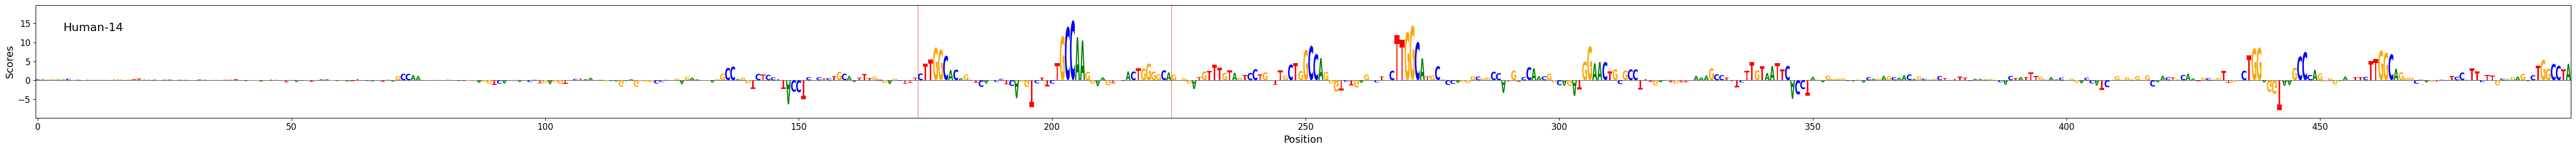

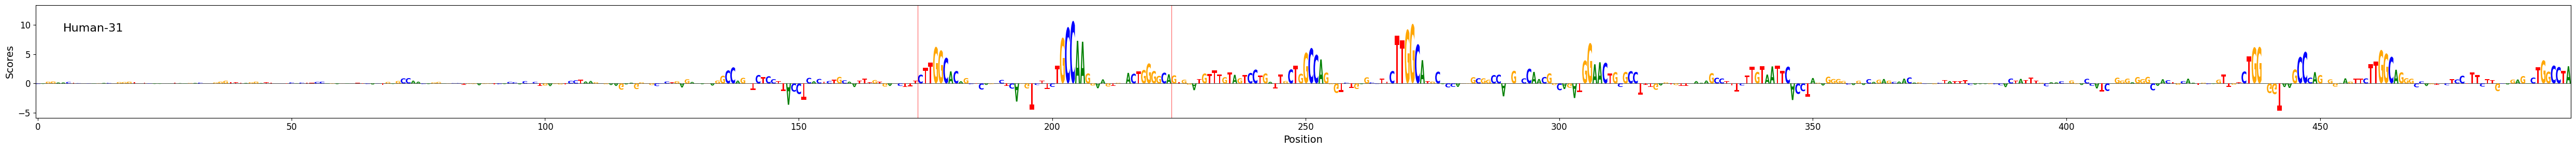

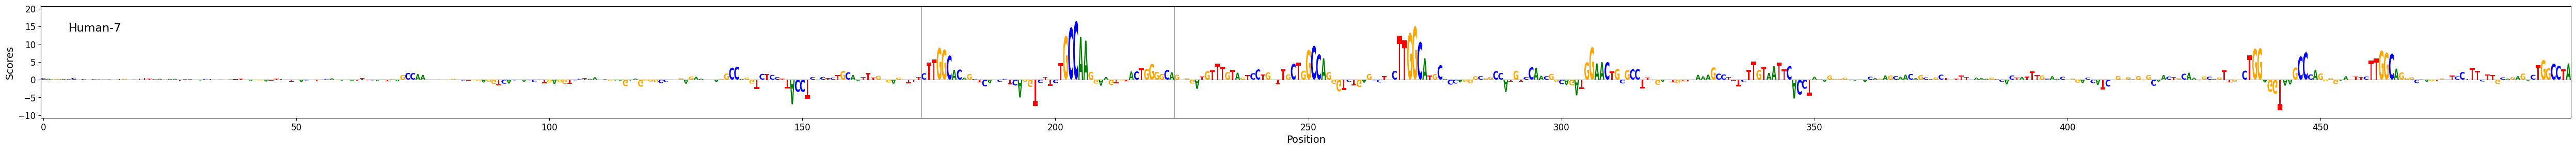

In [9]:
%matplotlib inline
visualize_seqlet_contribs(
    idx=9,
    all_contribs=all_contribs,
    all_seqs=all_seqs,
    seqlet_example_idcs=all_patterns['pos_patterns'][pattern_id]['seqlets']['example_idx'],
    seqlet_starts=all_patterns['pos_patterns'][pattern_id]['seqlets']['start'],
    seqlet_ends=all_patterns['pos_patterns'][pattern_id]['seqlets']['end'],
    adata=adata
)

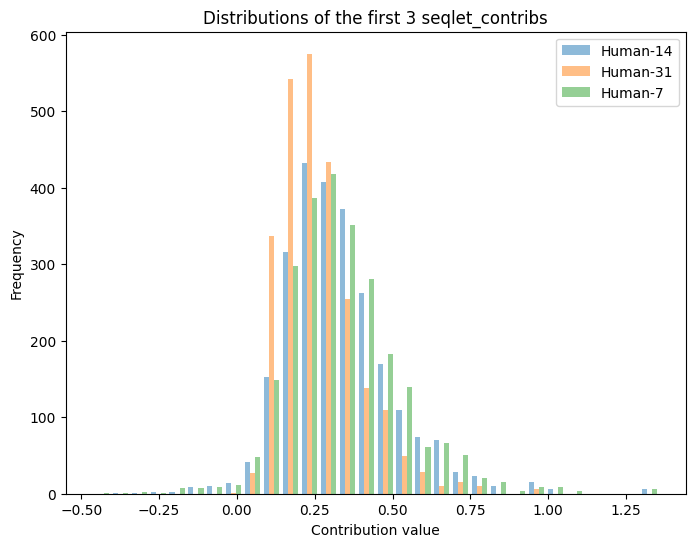

In [10]:
plot_seqlet_contrib_distributions(seqlet_contribs, adata, n=3, bins=30)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from vizsequence.viz_sequence import plot_weights_given_ax
from matplotlib.patches import Patch
from matplotlib import cm
from matplotlib.colors import Normalize

def plot_pattern_overview(
    all_patterns,
    pattern_ids,
    all_contribs,
    all_seqs,
    adata,
    tf_patterns={},
    stat='median',
    save_path=None,
):
    from numpy import median, mean
    stat_func = median if stat == 'median' else mean

    class_labels = list(adata.obs_names)[:3]
    colors = plt.get_cmap('tab10')(np.arange(3))

    # Determine global TF expression range across all mapped TFs
    vmin, vmax = get_global_tf_expr_range(tf_patterns, mean_expression_df)
    norm_color = Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.Reds

    fig, axes = plt.subplots(
        nrows=len(pattern_ids),
        ncols=4,
        figsize=(10, 1 * len(pattern_ids)),
        gridspec_kw={'width_ratios': [1, 1, 1, 0.2]},
        squeeze=False
    )

    for i, pattern_id in enumerate(pattern_ids):
        contrib_scores = crested.tl.modisco._tfmodisco._trim_pattern_by_ic(
            all_patterns['pos_patterns'][pattern_id],
            pos_pattern=True, min_v=0.025
        )['contrib_scores']
        contrib_scores = contrib_scores / contrib_scores.max()

        seqlet_contribs, counts = compute_seqlet_contribs(
            pattern_id, all_patterns, all_contribs, all_seqs
        )

        scale_vals = [stat_func(sc) for sc in seqlet_contribs]
        weighted_scores = [contrib_scores * s for s in scale_vals]

        all_vals = np.concatenate(weighted_scores)
        ymin, ymax = np.min(all_vals), np.max(all_vals)
        ylim = (ymin, ymax + 0.05 * (ymax - ymin))

        for j in range(3):
            ax = axes[i, j]
            plot_weights_given_ax(ax, weighted_scores[j])
            ax.set_ylim(ylim)
            ax.set_xticks([])
            if i == 0:
                ax.set_title(class_labels[j], fontsize=10)
            if j == 0:
                label = tf_patterns.get(pattern_id, pattern_id)
                axes[i, j].set_ylabel(label)

            # --- Expression dot in upper right ---
            tf_name = tf_patterns.get(pattern_id, None)
            if tf_name and tf_name in mean_expression_df.columns:
                tf_expr = get_normalized_tf_expression(tf_name, mean_expression_df)
                norm_expr = tf_expr[0, 1, j]  # normalized [0–1] for size
                raw_expr = tf_expr[0, 0, j]   # raw for color (shared scale)
            
                red_color = cmap(norm_color(raw_expr))
            
                ax.scatter(
                    0.9, 0.8,
                    transform=ax.transAxes,
                    s=norm_expr * 300,
                    color=red_color,
                    edgecolor='black',
                    linewidth=0.5,
                    zorder=10
                )

        # Vertical bar plot with class proportions
        bar_ax = axes[i, 3]
        bar_ax.axis("off")
        total = int(np.sum(counts))
        y_start = 0
        for k in range(3):
            frac = counts[k] / total if total > 0 else 0
            bar_ax.add_patch(plt.Rectangle((0.25, y_start), 0.5, frac, color=colors[k]))
            y_start += frac
        bar_ax.set_ylim(0, 1)
        
        # Add rotated text with prefix
        bar_ax.text(
            1.0, 0.5,
            f"Total seqlets:\n{total}",
            va='center',
            ha='center',
            fontsize=8,
            rotation=270
        )

    # Add shared legend
    legend_elements = [Patch(facecolor=colors[i], label=class_labels[i]) for i in range(3)]
    fig.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.02),
        ncol=3,
        fontsize=9
    )

    plt.tight_layout(h_pad=1)
    plt.subplots_adjust(top=0.95)
    # Add colorbar for raw expression values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_color)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes[:, :3], orientation='vertical', fraction=0.01, pad=0.01)
    cbar.set_label('TF expression')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


def get_normalized_tf_expression(tf_list, df):
    if(type(tf_list)==str):
        tf_list=[tf_list]
    expression_list = np.zeros((len(tf_list),2,3))
    for i, tf in enumerate(tf_list):
        exp = df[tf]
        exp_norm = exp/np.max(exp)
        expression_list[i][0]=exp
        expression_list[i][1]=exp_norm
    return expression_list

def get_global_tf_expr_range(tf_patterns, mean_expression_df):
    """
    Compute the global max expression across all TFs mapped to patterns.
    """
    tf_list = list(set(tf_patterns.values()))
    max_val = 0
    for tf in tf_list:
        if tf in mean_expression_df.columns:
            tf_vals = mean_expression_df[tf].values
            max_val = max(max_val, np.nanmax(tf_vals))
    return 0, max_val

In [12]:
import crested
import anndata

file_path = (
    "/allen/programs/celltypes/workgroups/rnaseqanalysis/hct_ux3_cellxgene/anndata_080/BasalGanglia/Astro/HMBA_human_Astro_3subGroups.h5ad"  # Locate h5 file containing scRNAseq data
)

adata_rna = anndata.read_h5ad(file_path)

In [13]:
cell_type_column = "Cluster"
mean_expression_df = crested.tl.modisco.calculate_mean_expression_per_cell_type(
    file_path, cell_type_column, cpm_normalize=False
)

/home/niklas.kempynck/miniconda3/envs/crested_testing/lib/python3.10/site-packages/crested/tl/modisco/_tfmodisco.py:1633: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expression_per_cell_type: pd.DataFrame = gene_expression_df.groupby(


In [14]:
mean_expression_df = mean_expression_df.loc[['Human-14', 'Human-31', 'Human-7']]

In [15]:
mean_expression_df['HLF']

Cluster
Human-14    0.993672
Human-31    0.305680
Human-7     1.568637
Name: HLF, dtype: float32

2534it [00:00, 37539.75it/s]
1173it [00:00, 37293.58it/s]
714it [00:00, 36293.20it/s]
313it [00:00, 36589.11it/s]
247it [00:00, 36554.57it/s]
230it [00:00, 36337.57it/s]
227it [00:00, 35628.75it/s]
193it [00:00, 36454.14it/s]
182it [00:00, 35644.53it/s]
180it [00:00, 36052.47it/s]
150it [00:00, 35771.30it/s]
146it [00:00, 36066.22it/s]
144it [00:00, 35658.27it/s]
139it [00:00, 34690.48it/s]
138it [00:00, 35904.35it/s]
124it [00:00, 36485.00it/s]
121it [00:00, 35874.09it/s]
109it [00:00, 35156.81it/s]
108it [00:00, 35216.11it/s]
92it [00:00, 35054.14it/s]
90it [00:00, 35618.74it/s]
89it [00:00, 35376.52it/s]
87it [00:00, 34568.44it/s]
87it [00:00, 34805.84it/s]
82it [00:00, 35041.56it/s]
80it [00:00, 35287.02it/s]
78it [00:00, 35098.78it/s]
73it [00:00, 35016.49it/s]
71it [00:00, 35059.52it/s]
70it [00:00, 35015.06it/s]
66it [00:00, 34930.48it/s]
58it [00:00, 34847.39it/s]
51it [00:00, 33412.92it/s]
41it [00:00, 33851.67it/s]
41it [00:00, 33391.55it/s]
33it [00:00, 32346.82it/s]
32it [0

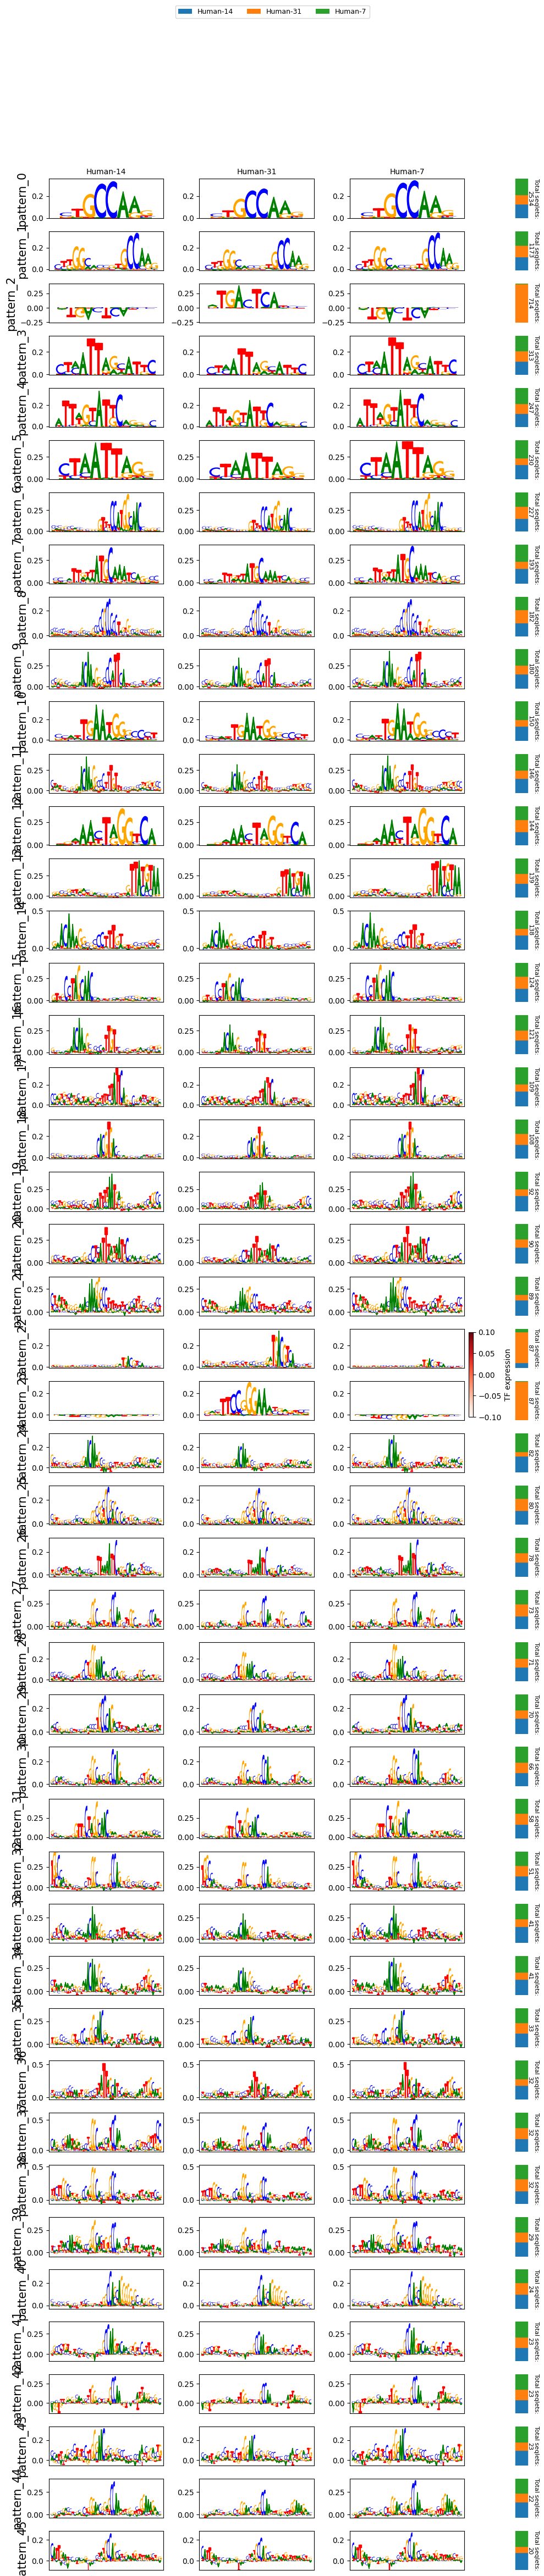

In [16]:


pattern_ids=['pattern_0', 'pattern_1', 'pattern_3', 
             'pattern_4','pattern_6','pattern_9',
            'pattern_10', 'pattern_12', 'pattern_13',
            'pattern_17', 'pattern_22', 'pattern_23',
            'pattern_30', 'pattern_33', 'pattern_35']
pattern_ids=['pattern_'+str(i) for i in range(46)]
#tf_patterns = {
#    'pattern_0':'NFIX',
#    'pattern_1':'NFIA',
#    'pattern_3':'RFX3',
#    'pattern_4':'LHX2',
#    'pattern_6':'SOX9',
#    'pattern_9':'SP1',
#    'pattern_10':'AR',
#    'pattern_12':'CTCF',
#    'pattern_13':'ZNF',
#    'pattern_17':'CREB5',
#    'pattern_23':'RORB',
#    'pattern_30':'CTCF',
#    'pattern_35':'RORB'
#}
#pattern_ids = ['pattern_4', 'pattern_9']

plot_pattern_overview(
    all_patterns,
    pattern_ids,
    all_contribs,
    all_seqs,
    adata,
    stat='mean',
)

2534it [00:00, 36998.60it/s]
1173it [00:00, 37097.86it/s]
714it [00:00, 36278.25it/s]
313it [00:00, 36014.96it/s]
230it [00:00, 36395.15it/s]
87it [00:00, 35056.63it/s]
87it [00:00, 34716.43it/s]


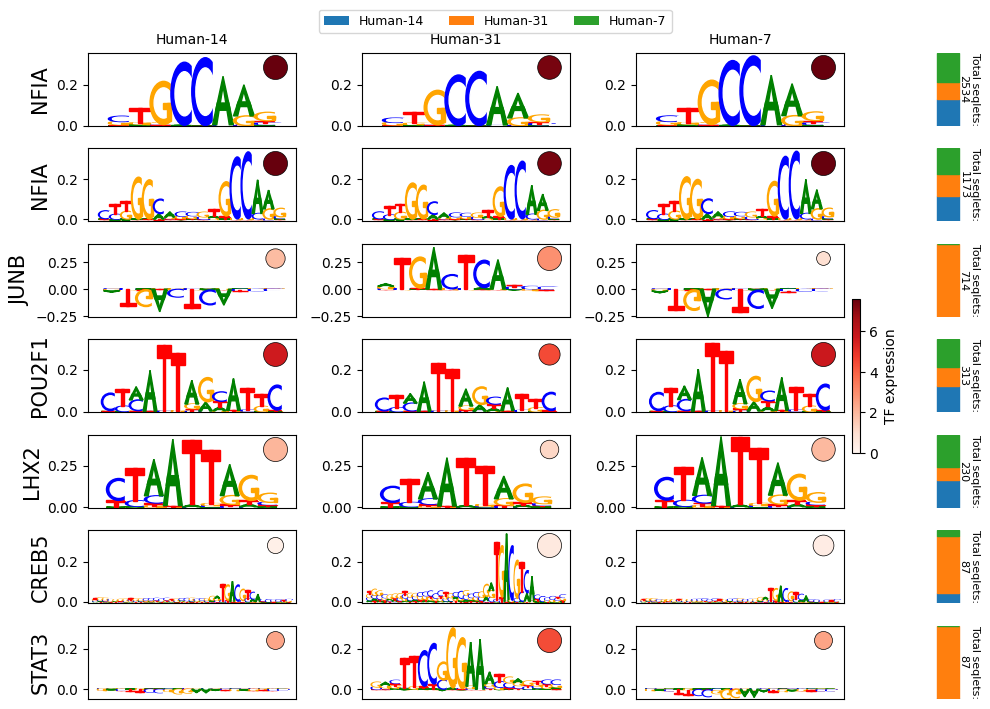

In [19]:


pattern_ids=['pattern_0', 'pattern_1', 'pattern_2', 
             'pattern_3','pattern_5','pattern_22',
            'pattern_23']
tf_patterns = {
    'pattern_0':'NFIA',
    'pattern_1':'NFIA',
    'pattern_2':'JUNB',
    'pattern_3':'POU2F1',
    'pattern_5':'LHX2',
    'pattern_22':'CREB5',
    'pattern_23': 'STAT3',
#    'pattern_12':'CTCF',
#    'pattern_13':'ZNF',
#    'pattern_17':'CREB5',
#    'pattern_23':'RORB',
#    'pattern_30':'CTCF',
#    'pattern_35':'RORB'
}

plot_pattern_overview(
    all_patterns,
    pattern_ids,
    all_contribs,
    all_seqs,
    adata,
    tf_patterns,
    stat='mean',
)